In [2]:
import cv2
import numpy as np
from numpy import sqrt, pi, reshape
import matplotlib.pyplot as plt

******* Leung-Malik filter ********

|18| -- first order derivative of gaussian
|  |    6 -- orientations
|  |    3 -- scales
|18| -- second order derivative of gaussian
|  |    6 -- orientations
|  |    3 -- scales
|08| -- Laplacian of Gaussian(LoG) filters
|04| -- Gaussians
-----------
|48| Filters 


In [34]:
def gaussian_filter(grid, sigma, elongation=1, elongate ='yes'):
    x, y = grid
    sigma_x = sigma
    
    if elongate == 'yes':
        sigma_y = elongation*sigma_x
        
    else:
        sigma_y = sigma_x
        
    numerator = np.exp(-(x**2/(2*sigma_x**2) + y**2/(2*sigma_y**2)))
    denominator = 2 * pi * sigma_x * sigma_y
    return numerator / denominator


def derivative_gaussian_filter(grid, sigma, elongation, order, elongate = 'yes'):
    
    gaussian = gaussian_filter(grid, sigma, elongation, elongate)
    x, y = grid
    sigma_x = sigma
    sigma_y = sigma_x * elongation
    
    # first partial x derivative
    if order == [1, 0]:
        first_derivate_x = (-x / sigma_x**2) * gaussian
        return first_derivate_x
    
    # first partial y derivative
    elif order == [0, 1]:
        first_derivate_y = (-y / sigma_y**2) * gaussian
        return first_derivate_y 
    
    # second partial x derivative
    elif order == [2, 0]:
        second_derivative_x = ((x**2 - sigma_x**2) / sigma_x**4) * gaussian
        return second_derivative_x
    
    # second partial y derivative
    elif order == [0, 2]:
        second_derivative_y = ((y**2 - sigma_y**2) / sigma_y**4) * gaussian
        return second_derivative_y
    
    # Laplcian of Gaussian
    elif order == [2, 2]:
        laplacian = ((x**2  + y**2 - 2* sigma**2) / sigma**4) * gaussian
        return laplacian
 

def LM(type):
    size = 49
    bound = size // 2
    spread = np.linspace(-bound, bound, size)
    x, y = np.meshgrid(spread, spread)
    grid = (x, y)
    elongation = 3
    orientations = 6
    
    if type =='small':
        scales = [1, sqrt(2), 2, 2*sqrt(2)]

    else:
        scales = [sqrt(2), 2, 2*sqrt(2), 4]
        
    LM_filters = []
    for sigma in scales[:3]: 
        first_derivate_x = derivative_gaussian_filter(grid, sigma, elongation, order = [1, 0], elongate = 'yes')
        first_derivative_gaussian = first_derivate_x 
        
        second_derivative_x = derivative_gaussian_filter(grid, sigma, elongation, order = [2, 0], elongate = 'yes')
        second_derivative_gaussian = second_derivative_x 
        
        for i in range(orientations):
            angle = i * 360 / orientations
            rot_matrix = cv2.getRotationMatrix2D((size//2, size//2), angle, 1)
            first_derivative_rotated = cv2.warpAffine(first_derivative_gaussian, rot_matrix, (size, size))
            LM_filters.append(first_derivative_rotated)

        for i in range(orientations):
            angle = i * 360 / orientations
            rot_matrix = cv2.getRotationMatrix2D((size//2, size//2), angle, 1)
            second_derivative_rotated = cv2.warpAffine(second_derivative_gaussian, rot_matrix, (size, size))
            LM_filters.append(second_derivative_rotated)
            
    for sigma in scales:
        laplacian = derivative_gaussian_filter(grid, sigma, elongation, order = [2, 2], elongate = 'no')
        LM_filters.append(laplacian)
        
    for sigma in scales:
        laplacian = derivative_gaussian_filter(grid, sigma*3, elongation, order = [2, 2], elongate = 'no')
        LM_filters.append(laplacian)
        
    for sigma in scales:
        gaussian = gaussian_filter(grid, sigma, elongation, elongate = 'no')
        LM_filters.append(gaussian)
        
    return LM_filters

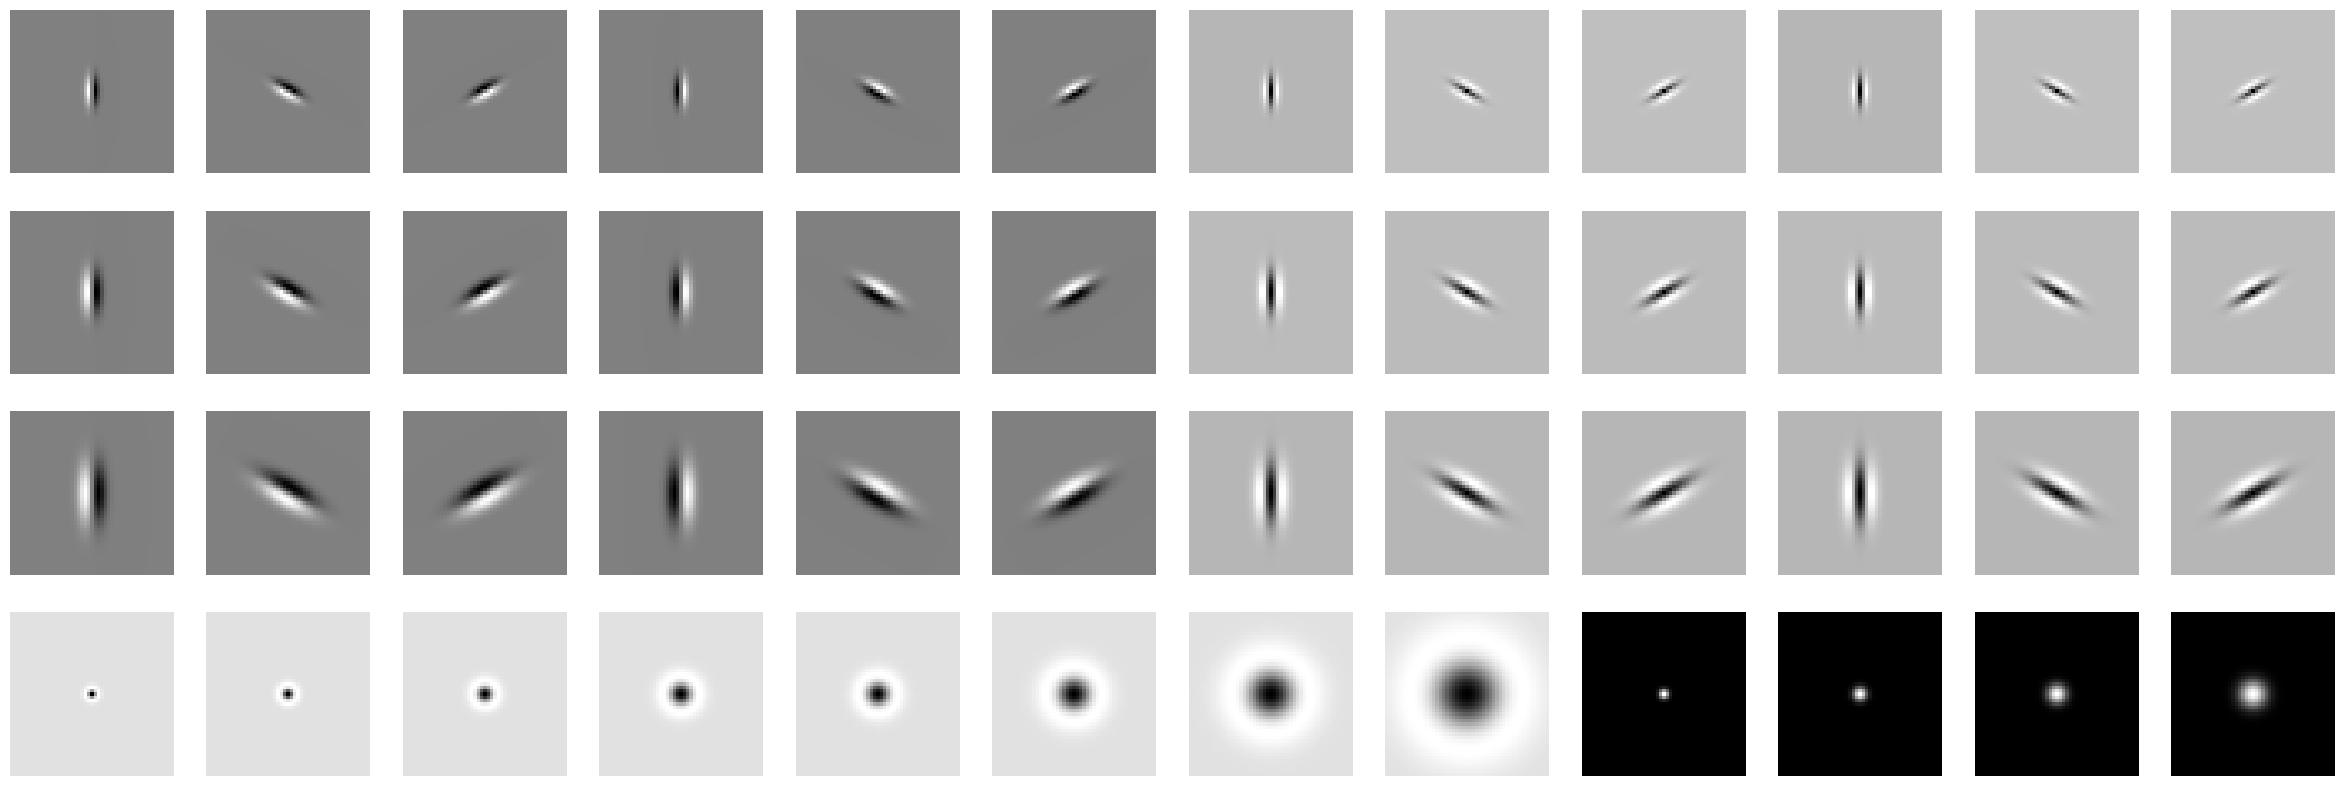

In [35]:
LM_filter_bank = LM('small')
fig, axs = plt.subplots(4, 12, figsize=(30, 10))
for i, filter in enumerate(LM_filter_bank):
    axs[i//12, i%12].imshow(filter, cmap='gray')
    axs[i//12, i%12].axis('off')